### Import libraries

In [52]:
pip install lazypredict

Note: you may need to restart the kernel to use updated packages.


In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from lazypredict.Supervised import LazyClassifier


### Read data

In [54]:
data = pd.read_csv("stroke_classification.csv")

### Preprocessing data

In [55]:
data.head()

,pat_id,stroke,gender,age,hypertension,heart_disease,work_related_stress,urban_residence,avg_glucose_level,bmi,smokes
0,1,1,Male,67.00,0,1,0,1,228.69,36.60,1
1,2,1,Female,61.00,0,0,1,0,202.21,NaN,0
2,3,1,Male,80.00,0,1,0,0,105.92,32.50,0
3,4,1,Female,49.00,0,0,0,1,171.23,34.40,1
4,5,1,Female,79.00,1,0,1,0,174.12,24.00,0


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pat_id               5110 non-null   int64  
 1   stroke               5110 non-null   int64  
 2   gender               5110 non-null   object 
 3   age                  5110 non-null   float64
 4   hypertension         5110 non-null   int64  
 5   heart_disease        5110 non-null   int64  
 6   work_related_stress  5110 non-null   int64  
 7   urban_residence      5110 non-null   int64  
 8   avg_glucose_level    5110 non-null   float64
 9   bmi                  4909 non-null   float64
 10  smokes               5110 non-null   int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 439.3+ KB


There are some NaN in the bmi variable. This is a quantitative variable so we can handle NaN by replacing it with the median.


### Data visulization

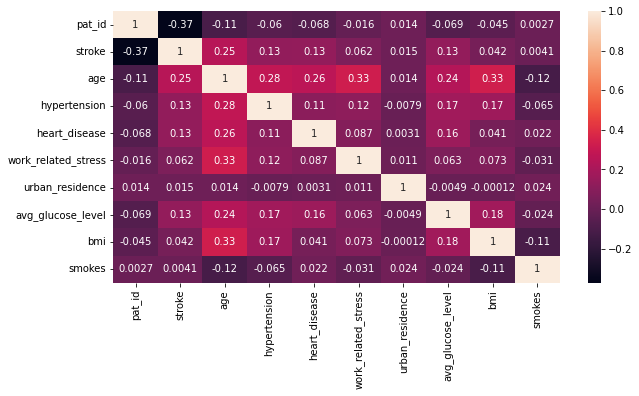

In [57]:
plt.figure(figsize=(10,5))
sns.heatmap(data.corr(), annot=True)
plt.show()

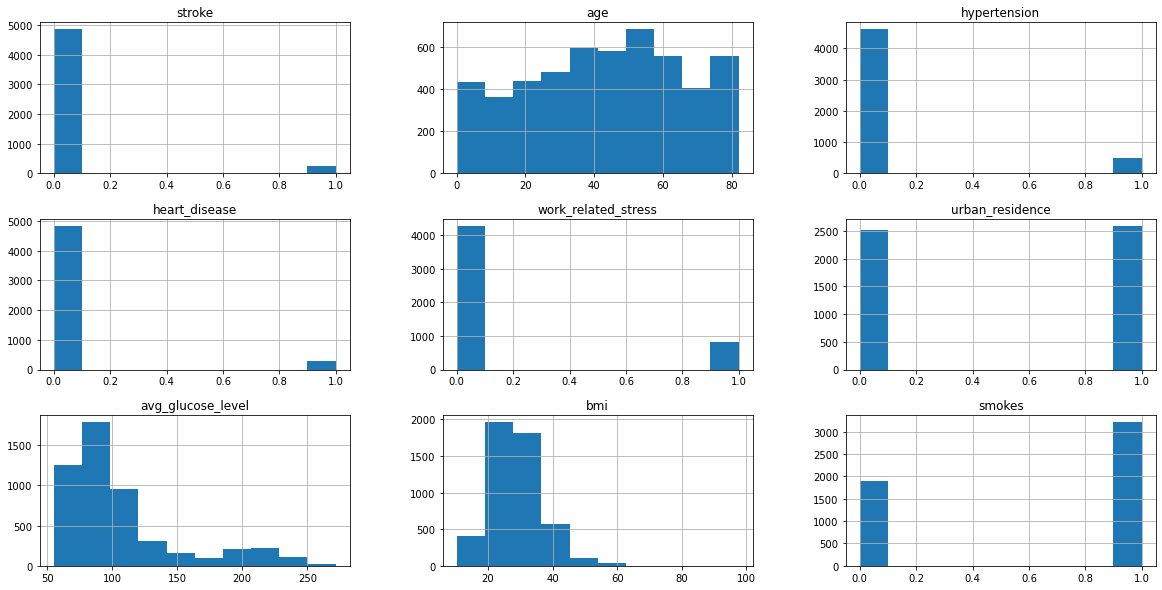

In [58]:
data.iloc[:,1:].hist(figsize=(20,10))
plt.show()

- Features :

Boulean variable : hypertension, heart_disease, work_related_stress, urban_residence, smokes

Categorical variable : gender

Quantitative variable : age, avg_glucose_level, bmi

- Target : 
Boulean variable : stroke 

In [59]:
data["gender"].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [60]:
data["stroke"].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

The ratio between the values 1 and 0 in the outcome variable "stroke" varies by about 5.12%. We will test 2 options :
- 1 model with the original outcome variable "stroke" 
- 1 modell using the sampling method to balance the values in outcome variable "stroke"

### Build model without resampling

In [61]:
x = data.drop(["stroke","pat_id"], axis=1)
y = data["stroke"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)

- Features :

Boulean variable : hypertension, heart_disease, work_related_stress, urban_residence, smokes

Quantitative variable : age, avg_glucose_level, bmi

Categorical variable : gender

- Target : 
Boulean variable : stroke 

In [62]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', OneHotEncoder(sparse=False))
    ])

preprocessor = ColumnTransformer(transformers=[
    ("num_features", numerical_transformer, ["age","avg_glucose_level","bmi"]),
    ("ord_features", nominal_transformer, ["gender"])
    ])

# model Random Forest Classifier
cls = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier())
    ])


In [63]:
cls.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('ord_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   OneHotEncoder(sparse

In [64]:
y_predict = cls.predict(x_test)

In [65]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       976
           1       0.00      0.00      0.00        46

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.91      0.95      0.93      1022



### Build model with resampling

In [66]:
x = data.drop(["stroke","pat_id"], axis=1)
y = data["stroke"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)

ros = RandomOverSampler(random_state=100)
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)

y_resampled.value_counts()

0    3885
1    3885
Name: stroke, dtype: int64

In [67]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', OneHotEncoder(sparse=False))
    ])

preprocessor = ColumnTransformer(transformers=[
    ("num_features", numerical_transformer, ["age","avg_glucose_level","bmi"]),
    ("ord_features", nominal_transformer, ["gender"])
    ])
params = {
    "n_estimators": [50, 100, 200],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_features": ["sqrt", "log2", None]
}
# model Random Forest Classifier
cls = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier())
    ])

In [68]:
cls.fit(x_resampled, y_resampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('ord_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   OneHotEncoder(sparse

In [69]:
y_predict = cls.predict(x_test)

In [70]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       976
           1       0.14      0.07      0.09        46

    accuracy                           0.94      1022
   macro avg       0.55      0.52      0.53      1022
weighted avg       0.92      0.94      0.93      1022



### Build model with LazyClassifier (resampled)

In [71]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(x_resampled, x_test, y_resampled, y_test)
models

 97%|███████████████████████████████████████████████████████████████████████████████▏  | 28/29 [00:33<00:01,  1.15s/it]

[LightGBM] [Info] Number of positive: 3885, number of negative: 3885
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 7770, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:33<00:00,  1.15s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,0.70,0.79,0.79,0.79,0.55
NearestCentroid,0.71,0.79,0.79,0.79,0.04
RidgeClassifierCV,0.70,0.78,0.78,0.79,0.05
CalibratedClassifierCV,0.72,0.78,0.78,0.80,3.61
LinearDiscriminantAnalysis,0.70,0.78,0.78,0.79,0.05
RidgeClassifier,0.70,0.78,0.78,0.79,0.05
LogisticRegression,0.71,0.78,0.78,0.80,0.06
LinearSVC,0.70,0.77,0.77,0.79,1.44
BernoulliNB,0.68,0.76,0.76,0.77,0.05


### Build model with GridSearchCV

In [72]:
x = data.drop(["stroke","pat_id"], axis=1)
y = data["stroke"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)

ros = RandomOverSampler(random_state=100)
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)

y_resampled.value_counts()

0    3885
1    3885
Name: stroke, dtype: int64

In [73]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', OneHotEncoder(sparse=False))
    ])

preprocessor = ColumnTransformer(transformers=[
    ("num_features", numerical_transformer, ["age","avg_glucose_level","bmi"]),
    ("ord_features", nominal_transformer, ["gender"])
    ])
params = {
    "n_estimators": [50, 100, 200],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_features": ["sqrt", "log2", None]
}
# model Random Forest Classifier
cls = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GridSearchCV(RandomForestClassifier(random_state=100), param_grid=params, cv=6, verbose=1, n_jobs=-1))
    ])

In [74]:
cls.fit(x_resampled, y_resampled)

Fitting 6 folds for each of 27 candidates, totalling 162 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('ord_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   OneHotEncoder(sparse

In [75]:
y_predict = cls.predict(x_test)

In [76]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       976
           1       0.24      0.15      0.19        46

    accuracy                           0.94      1022
   macro avg       0.60      0.56      0.58      1022
weighted avg       0.93      0.94      0.93      1022

